# 0 Import

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import torchvision.models as models
import string
import timm
import nltk
nltk.download('punkt_tab')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


[nltk_data] Downloading package punkt_tab to /home/white/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# 1 Dataset

In [4]:
# captions_file = '../data/train_small/small_captions_train.txt'
captions_file = '../data/train/captions_train.txt'

captions_df = pd.read_table(captions_file, delimiter=',', header=None, names=['image', 'caption'])

captions_df.head()

,image,caption
0,1000092795.jpg,Two young guys with shaggy hair look at their...
1,1000092795.jpg,"Two young , White males are outside near many..."
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .


## 1.1 Dataframe

In [5]:
# Get only unique images
unique_images = captions_df['image'].unique()

# Split images
train_images, test_images = train_test_split(unique_images, test_size=0.2, random_state=42)
train_images, val_images = train_test_split(train_images, test_size=0.1, random_state=42)

# DataFrame creation
train_df = captions_df[captions_df['image'].isin(train_images)].reset_index(drop=True)
train_df = train_df.dropna().reset_index(drop=True)
val_df = captions_df[captions_df['image'].isin(val_images)].reset_index(drop=True)
val_df = val_df.dropna().reset_index(drop=True)
test_df = captions_df[captions_df['image'].isin(test_images)].reset_index(drop=True)
test_df = test_df.dropna().reset_index(drop=True)

print(f"Numero di immagini nel set di addestramento: {len(train_images)}")
print(f"Numero di immagini nel set di validazione: {len(val_images)}")
print(f"Numero di immagini nel set di test: {len(test_images)}")

Numero di immagini nel set di addestramento: 16018
Numero di immagini nel set di validazione: 1780
Numero di immagini nel set di test: 4450


## 1.2 Vocabulary class

In [6]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.word2idx = {'<PAD>': 0, '<START>': 1, '<END>': 2, '<UNK>': 3}
        self.idx2word = {0: '<PAD>', 1: '<START>', 2: '<END>', 3: '<UNK>'}
        self.word_freq = {}
        self.idx = 4
        # self.translator = str.maketrans("","", string.punctuation + string.digits + "\t\r\n")
         

    def __len__(self):
        return len(self.word2idx)

    def tokenize(self, text):
        return nltk.tokenize.word_tokenize(text)

    def build_vocabulary(self, sentence_list):
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                if word not in self.word_freq:
                    self.word_freq[word] = 1
                else:
                    self.word_freq[word] += 1

                if self.word_freq[word] == self.freq_threshold:
                    self.word2idx[word] = self.idx
                    self.idx2word[self.idx] = word
                    self.idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenize(text)
        return [self.word2idx.get(word, self.word2idx['<UNK>']) for word in tokenized_text]

In [7]:
vocab = Vocabulary(freq_threshold=5)
caption_list = train_df['caption'].tolist()
vocab.build_vocabulary(caption_list)

print(f"Dimensione del vocabolario: {len(vocab)}")

Dimensione del vocabolario: 5900


## 1.3 Glove (200)

In [8]:
def load_glove_embeddings(glove_file):
    embeddings = {}
    with open(glove_file, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    print(f"Caricati {len(embeddings)} vettori di embedding da GloVe.")
    return embeddings

# Caricamento degli embeddings GloVe
glove_file = '../glove/glove.6B.200d.txt'  # Sostituisci con il percorso corretto
glove_embeddings = load_glove_embeddings(glove_file)

def create_embedding_matrix(vocab, glove_embeddings, embedding_dim):
    vocab_size = len(vocab)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, idx in vocab.word2idx.items():
        if word in glove_embeddings:
            embedding_matrix[idx] = glove_embeddings[word]
        else:
            # Inizializza con un vettore casuale per le parole non trovate
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))
    return torch.tensor(embedding_matrix, dtype=torch.float32)

embedding_dim = 200
embedding_matrix = create_embedding_matrix(vocab, glove_embeddings, embedding_dim)

Caricati 400000 vettori di embedding da GloVe.


## 1.4 Dataset class

In [9]:
class FlickrDataset(Dataset):
    def __init__(self, dataframe, image_dir, vocab, transform=None):
        self.image_dir = image_dir
        self.vocab = vocab
        self.transform = transform

        # Creiamo una lista di coppie (immagine, didascalia)
        self.image_ids = []
        self.captions = []

        grouped = dataframe.groupby('image')['caption'].apply(list).reset_index()

        for idx in range(len(grouped)):
            img_id = grouped.loc[idx, 'image']
            captions = grouped.loc[idx, 'caption']
            for cap in captions:
                self.image_ids.append(img_id)
                self.captions.append(cap)

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        caption = self.captions[idx]
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id)
        image = Image.open(image_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        numericalized_caption = [self.vocab.word2idx['<START>']]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.word2idx['<END>'])
        numericalized_caption = torch.tensor(numericalized_caption)

        return image, numericalized_caption

### 1.4.1 Transformation Sequence

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    ),
])

transf_totensor = transforms.Compose([transforms.ToTensor()])

## 1.5 Dataset creation

In [11]:
# image_dir = '../data/train_small'
image_dir = '../data/train'

train_dataset = FlickrDataset(train_df, image_dir, vocab, transform=transform)
val_dataset = FlickrDataset(val_df, image_dir, vocab, transform=transform)
test_dataset = FlickrDataset(test_df, image_dir, vocab, transform=transform)
test_dataset_or = FlickrDataset(test_df, image_dir, vocab, transform=transf_totensor)

In [12]:
def collate_fn(batch):
    images = []
    captions = []
    for img, cap in batch:
        images.append(img)
        captions.append(cap)
    images = torch.stack(images, dim=0)
    captions = nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=vocab.word2idx['<PAD>'])
    return images, captions

In [13]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)

# 2 Model

## 2.1 Encoder (VIT)

In [14]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        # Carica il modello ViT pre-addestrato
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        # Congela i parametri del ViT
        for param in self.vit.parameters():
            param.requires_grad = False
        # Rimuovi il classificatore
        self.vit.reset_classifier(0)
        # Aggiungi un layer fully connected per mappare a embed_size
        self.fc = nn.Linear(self.vit.num_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
    
    def forward(self, images):
        # Estrae le feature
        features = self.vit.forward_features(images)  # [batch_size, seq_len, embed_dim]
        # Prende la rappresentazione del token [CLS]
        cls_features = features[:, 0, :]  # [batch_size, embed_dim]
        # Applica il layer fully connected e la batch normalization
        features = self.bn(self.fc(cls_features))
        return features  # [batch_size, embed_size]

## 2.2 Decoder (LSTM)

In [15]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, embedding_matrix, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
        # init hidden state
        self.init_h = nn.Linear(embed_size, hidden_size)
        self.init_c = nn.Linear(embed_size, hidden_size)
    
    def forward(self, features, captions):
        embeddings = self.embed(captions)  # [batch_size, seq_len, embed_size]
        
        # init hidden state with features
        h0 = self.init_h(features).unsqueeze(0)  # [num_layers, batch_size, hidden_size]
        c0 = self.init_c(features).unsqueeze(0)  # [num_layers, batch_size, hidden_size]
        
        # Passa gli embeddings e lo stato nascosto all'LSTM
        hiddens, _ = self.lstm(embeddings, (h0, c0))
        outputs = self.fc(hiddens)
        return outputs
    
    def sample(self, features, max_len=20):
        "Genera una didascalia data l'immagine"
        sampled_ids = []
        
        inputs = features.unsqueeze(1)  # [batch_size, 1, embed_size]
        h0 = self.init_h(features).unsqueeze(0)
        c0 = self.init_c(features).unsqueeze(0)
        
        states = (h0, c0)
        for _ in range(max_len):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.fc(hiddens.squeeze(1))
            _, predicted = outputs.max(1)
            sampled_ids.append(predicted.item())
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)
            if predicted.item() == vocab.word2idx['<END>']:
                break
        return sampled_ids

## 2.3 Embedding matrix function

In [16]:
def create_embedding_matrix(vocab, glove_embeddings, embedding_dim):
    vocab_size = len(vocab)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, idx in vocab.word2idx.items():
        if word in glove_embeddings:
            embedding_matrix[idx] = glove_embeddings[word]
        else:
            # Inizializza con un vettore casuale per le parole non trovate
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))
    return torch.tensor(embedding_matrix, dtype=torch.float32)

In [17]:
embed_size = 200
hidden_size = 512
vocab_size = len(vocab)

encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, embedding_matrix).to(device)

# 3 Training

In [18]:
learning_rate = 3e-4

for param in decoder.embed.parameters():
    param.requires_grad = False

decoder_optimizer = torch.optim.Adam([
    {'params': decoder.lstm.parameters()},
    {'params': decoder.fc.parameters()}
], lr=3e-4)

## 3.1 Training function

In [19]:
def train_model(encoder, decoder, criterion, decoder_optimizer, dataloader, valdataloader, num_epochs):
    encoder.train()
    decoder.train()

    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):

        # training phase
        for i, (images, captions) in enumerate(dataloader):
            images = images.to(device)
            captions = captions.to(device)

            decoder_optimizer.zero_grad()

            # Forward pass
            features = encoder(images)
            outputs = decoder(features, captions[:, :-1]) 

            # loss computation
            loss = criterion(outputs.reshape(-1, outputs.size(2)), captions[:, 1:].reshape(-1))
            train_losses.append(loss.item())

            # Backward pass e optim
            loss.backward()
            decoder_optimizer.step()

            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(dataloader)}], Loss: {loss.item():.4f}")
        
        # validation phase
        for i, (images, captions) in enumerate(valdataloader):
            images = images.to(device)
            captions = captions.to(device)

            # Forward pass
            features = encoder(images)
            outputs = decoder(features, captions[:, :-1]) 

            # loss computation
            loss = criterion(outputs.reshape(-1, outputs.size(2)), captions[:, 1:].reshape(-1))
            val_losses.append(loss.item())


    return train_losses, val_losses

/home/white/miniconda3/envs/dml/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  self.padding, self.dilation, self.groups)


Epoch [1/10], Step [0/2503], Loss: 8.6830
Epoch [1/10], Step [100/2503], Loss: 5.2506
Epoch [1/10], Step [200/2503], Loss: 4.7478
Epoch [1/10], Step [300/2503], Loss: 4.5253
Epoch [1/10], Step [400/2503], Loss: 4.2457
Epoch [1/10], Step [500/2503], Loss: 4.0663
Epoch [1/10], Step [600/2503], Loss: 4.1768
Epoch [1/10], Step [700/2503], Loss: 4.3896
Epoch [1/10], Step [800/2503], Loss: 4.0129
Epoch [1/10], Step [900/2503], Loss: 3.9764
Epoch [1/10], Step [1000/2503], Loss: 4.0888
Epoch [1/10], Step [1100/2503], Loss: 3.9792
Epoch [1/10], Step [1200/2503], Loss: 3.7578
Epoch [1/10], Step [1300/2503], Loss: 3.5689
Epoch [1/10], Step [1400/2503], Loss: 3.9928
Epoch [1/10], Step [1500/2503], Loss: 3.8966
Epoch [1/10], Step [1600/2503], Loss: 3.7407
Epoch [1/10], Step [1700/2503], Loss: 3.3214
Epoch [1/10], Step [1800/2503], Loss: 3.3424
Epoch [1/10], Step [1900/2503], Loss: 3.3899
Epoch [1/10], Step [2000/2503], Loss: 3.6388
Epoch [1/10], Step [2100/2503], Loss: 3.5995
Epoch [1/10], Step [22

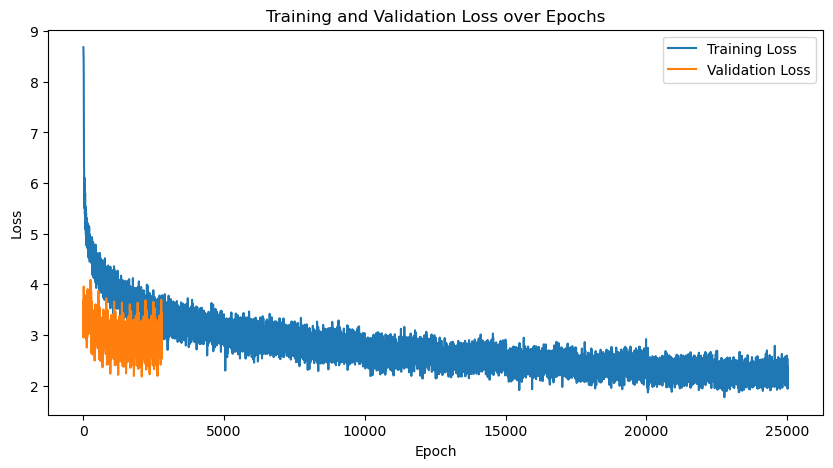

In [20]:
num_epochs = 10
criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx["<PAD>"])
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
# train_losses, val_losses = train_model(
#     encoder, decoder, criterion, decoder_optimizer, train_loader, val_loader, num_epochs
# )

plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 4 Caption generation and testing

In [35]:
def generate_caption(encoder, decoder, image, vocab, max_length=20):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        image = image.to(device)
        feature = encoder(image.unsqueeze(0))
        sampled_ids = decoder.sample(feature, max_length)
        sampled_caption = []
        for word_id in sampled_ids:
            word = vocab.idx2word[word_id]
            if word == '<END>':
                break
            sampled_caption.append(word)
        sentence = [sampled_caption[0]]
        for c in sampled_caption:
            if sentence[-1] != c:
                sentence.append(c)
        sentence = ' '.join(sentence)
    return sentence

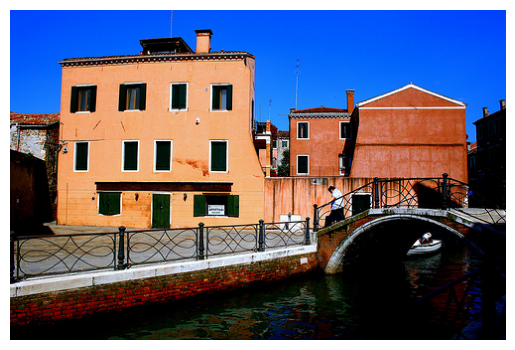

Caption idx 16262: gondola elderly man walking down a street .


In [51]:
import random

# image picking
idx = random.randint(0, len(test_dataset))
test_image, _ = test_dataset[idx]
print_image, _ = test_dataset_or[idx]
plt.imshow(print_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

# caption generation
caption = generate_caption(encoder, decoder, test_image, vocab)
print(f"Caption idx {idx}: {caption}")

## 4.1 Plot losses

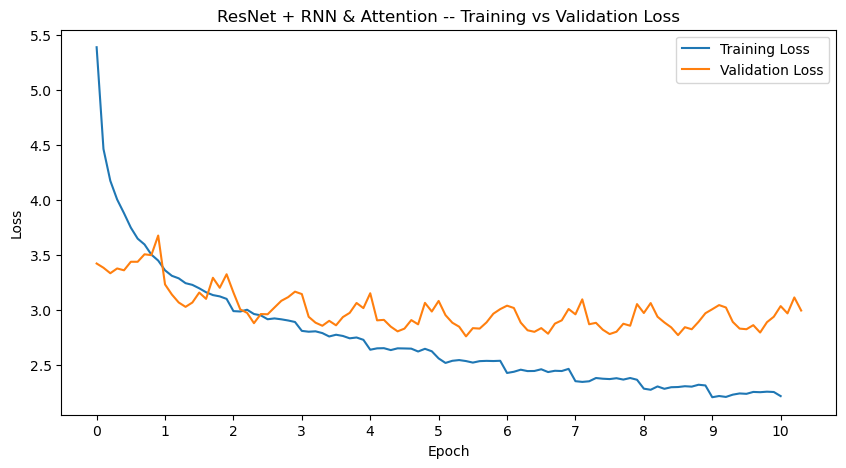

In [42]:
def mean(l): return sum(l)/len(l)

lt = len(train_losses)
lv = len(val_losses)
step = 100
t_l = [mean(train_losses[i:min(i+lt//step, lt)]) for i in range(0, lt, lt//step)]
v_l = [mean(val_losses[i:min(i+lv//step, lv)]) for i in range(0, lv, lv//step)]
plt.figure(figsize=(10,5))
plt.plot(t_l, label='Training Loss')
plt.plot(v_l, label='Validation Loss')
plt.title('ResNet + RNN & Attention -- Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(ticks=range(0, len(t_l), 10), labels=range(0, 11))
plt.legend()
plt.show()
# plt.savefig('../img/vit_rnn.pdf', format='pdf')

# 5 Checkpoint

In [25]:
# save model
# torch.save(
#     {
#         "encoder_state_dict": encoder.state_dict(),
#         "decoder_state_dict": decoder.state_dict(),
#         "train_losses": train_losses,
#         "val_losses": val_losses,
#     },
#     "../ckpt/vit_rnn.ckpt",
# )

checkpoint = torch.load("../ckpt/vit_rnn.ckpt")

encoder = EncoderCNN(embed_size).to(device)
encoder.load_state_dict(checkpoint["encoder_state_dict"])
encoder = encoder.to(device)

decoder = DecoderRNN(embed_size, hidden_size, vocab_size, embedding_matrix).to(device)
decoder.load_state_dict(checkpoint["decoder_state_dict"])
decoder = decoder.to(device)

train_losses = checkpoint["train_losses"]
val_losses = checkpoint["val_losses"]